# Gradient Guided Network

This is code for article "Few-shot Regression with Differentiable Reference Model"

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import cos, sin, pi

In [2]:
# For reproducibility
seed = 2023
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
device = "mps"

In [3]:
# Data, for sine function
# Target function
def func(x):
    return np.sin(x)
# Piece-wise linear reference model
def model(x):
    if x < pi / 2:
        return x / pi * 2
    elif x < 1.5 * pi:
        return 2 - x / pi * 2
    else:
        return x / pi * 2 - 4
# Gradient of reference model
def difference(x):
    if x < pi / 2:
        return 2 / pi
    elif x < 3 * pi / 2:
        return -2 / pi
    else:
        return 2 / pi

# Numpy vectorize
model = np.vectorize(model)
difference = np.vectorize(difference)

# Dataset
xlim = [0, 2*pi]
training_set_size = 4                        # Training set size
training_set_size_d = 100                    # Gradient sample size

# Dataset1: sample from target function
x_train_1 = np.random.random(training_set_size) * (xlim[1] - xlim[0]) + xlim[0]
y_train_1 = func(x_train_1)

# Dataset2: gradient of reference model
x_train_2 = np.linspace(xlim[0], xlim[1], num=training_set_size_d)
y_train_2 = difference(x_train_2)

# Change to PyTorch tensor
x_train_1 = torch.tensor(x_train_1, dtype=torch.float32).view((-1, 1))
y_train_1 = torch.tensor(y_train_1, dtype=torch.float32).view((-1, 1))
x_train_2 = torch.tensor(x_train_2, dtype=torch.float32).view((-1, 1))
y_train_2 = torch.tensor(y_train_2, dtype=torch.float32).view((-1, 1))

In [4]:
# Network architecture
class Net(nn.Module):
    def __init__(self, hidden_size=10):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        h = torch.sigmoid(self.fc1(x))
        x = self.fc2(h)
        return x, h

In [5]:
# Network, loss function, and optimizer
net = Net(32)
loss_func = nn.MSELoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=0.01)

# Coefficient of gradient loss
alpha = 20 * training_set_size / training_set_size_d

num_epochs = 200

# Training
for epoch in range(num_epochs):
    # First stage: optimize target function
    y_pred, _ = net(x_train_1)
    mse = loss_func(y_pred, y_train_1)
    optimizer.zero_grad()
    mse.backward()
    optimizer.step()
    
    # Second stage: optimize the gradient
    # Calculate the gradient of inner points
    _, hidden = net(x_train_2)
    dy_dx = net.fc2.weight * hidden * (1-hidden) @ net.fc1.weight  # for sigmoid
    
    # Loss of gradient
    gn_mse = alpha * loss_func(dy_dx, y_train_2)
    
    # Optimize
    optimizer.zero_grad()
    gn_mse.backward()
    optimizer.step()

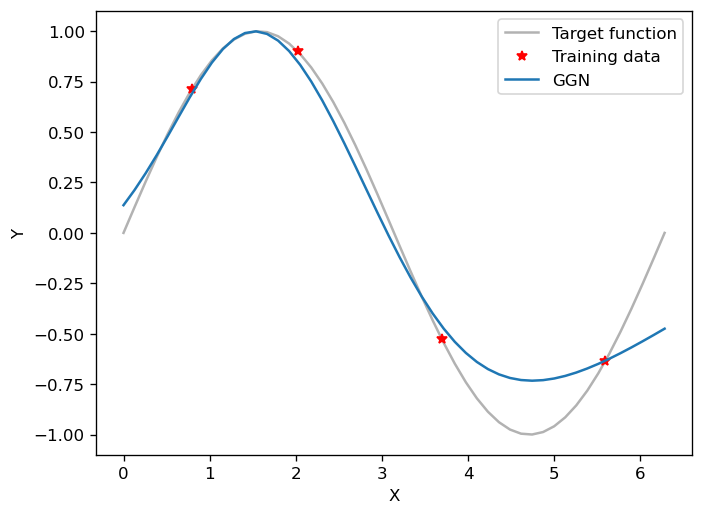

In [6]:
# Preidction

# Target function
x_test = np.linspace(xlim[0], xlim[1])
y_test = func(x_test)

# Predict
net.eval()
with torch.no_grad():
    x_test_t = torch.tensor(x_test, dtype=torch.float32).view((-1, 1))
    y_pred, _ = net(x_test_t)

plt.figure(dpi=120)
plt.plot(x_test, y_test, 'k', alpha=0.3, label="Target function")
plt.plot(x_train_1, y_train_1, 'r*', label="Training data")
plt.plot(x_test, y_pred.numpy().reshape(-1), label="GGN")

plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()